<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Получение-эмбеддингов" data-toc-modified-id="Получение-эмбеддингов-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Получение эмбеддингов</a></span><ul class="toc-item"><li><span><a href="#Предварительно-сформированные-от-DeepPavlov" data-toc-modified-id="Предварительно-сформированные-от-DeepPavlov-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Предварительно сформированные от DeepPavlov</a></span></li><li><span><a href="#Предварительно-сформированные-Distilbert" data-toc-modified-id="Предварительно-сформированные-Distilbert-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Предварительно сформированные Distilbert</a></span></li></ul></li><li><span><a href="#Уменьшение-размерности-эмбеддингов-для-задач-кластеризации" data-toc-modified-id="Уменьшение-размерности-эмбеддингов-для-задач-кластеризации-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Уменьшение размерности эмбеддингов для задач кластеризации</a></span><ul class="toc-item"><li><span><a href="#Метод-главных-компонент-PCA-от-Sklearn" data-toc-modified-id="Метод-главных-компонент-PCA-от-Sklearn-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Метод главных компонент PCA от Sklearn</a></span></li><li><span><a href="#Метод-нелинейного-снижения-размерности-UMAP" data-toc-modified-id="Метод-нелинейного-снижения-размерности-UMAP-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Метод нелинейного снижения размерности UMAP</a></span></li></ul></li><li><span><a href="#Кластеризация" data-toc-modified-id="Кластеризация-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Кластеризация</a></span><ul class="toc-item"><li><span><a href="#Агломеративная-кластеризация-Sklearn" data-toc-modified-id="Агломеративная-кластеризация-Sklearn-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Агломеративная кластеризация Sklearn</a></span></li><li><span><a href="#Кластеризация-HDBSCAN" data-toc-modified-id="Кластеризация-HDBSCAN-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Кластеризация HDBSCAN</a></span></li></ul></li><li><span><a href="#Визуализация-результатов-кластеризации" data-toc-modified-id="Визуализация-результатов-кластеризации-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Визуализация результатов кластеризации</a></span></li><li><span><a href="#Key-phrase" data-toc-modified-id="Key-phrase-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Key phrase</a></span></li><li><span><a href="#Summarization" data-toc-modified-id="Summarization-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Summarization</a></span></li></ul></div>

In [20]:
pip install spaCy

     ---------------------------------------- 0.0/12.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.2 MB ? eta -:--:--
     --------------------------------------- 0.0/12.2 MB 262.6 kB/s eta 0:00:47
     --------------------------------------- 0.1/12.2 MB 363.1 kB/s eta 0:00:34
     --------------------------------------- 0.1/12.2 MB 435.7 kB/s eta 0:00:28
     --------------------------------------- 0.1/12.2 MB 479.3 kB/s eta 0:00:26
     --------------------------------------- 0.2/12.2 MB 508.4 kB/s eta 0:00:24
      -------------------------------------- 0.2/12.2 MB 562.0 kB/s eta 0:00:22
      -------------------------------------- 0.2/12.2 MB 565.6 kB/s eta 0:00:22
      -------------------------------------- 0.2/12.2 MB 533.8 kB/s eta 0:00:23
      -------------------------------------- 0.3/12.2 MB 589.5 kB/s eta 

In [22]:
import pandas as pd
import numpy as np
import json
import re

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches    

import plotly.express as px
import seaborn as sn

from phik.report import plot_correlation_matrix

from tqdm import tqdm

import umap
import hdbscan

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer

from sentence_transformers import SentenceTransformer

import spacy

In [60]:
RANDOM_STATE = 3141592654

INPUT_FILES_PATH = 'input_data'
INTERNAL_FILES_PATH = 'internal_data'
OUTPUT_FILES_PATH = 'output_data'

CORPUS_FILE_NAME = 'corpus_lemm.csv'
WCOUNTS_FILE_NAME = 'word_counts.csv'
LABELS_DICT_FILE_NAME = 'labels.json'
KEYWORD_DICT_NAME = 'keywords.json'
MODEL_FILE_NAME = 'best_model.pkl'
OUT_CONT_NAME = 'model_cont.pkl'
BERT_MODEL_PATH_NAME = 'bert_model_trained'
EMB_FILE_NAME = 'embeddings.npy'
EMB_CLASSIC_FILE_NAME = 'embeddings_classic.npy'
EMB_ST_FILE_NAME = 'embeddings_st.npy'

TEXT_COLUMN_NAME = 'text'
CLASS_LABELS_NAME = 'class_labels'

In [3]:
data_lemmatized = pd.read_csv(f'{INTERNAL_FILES_PATH}/data_lemmatized.csv')
data = pd.read_csv(f'{INPUT_FILES_PATH}/data.csv', sep=';')

In [4]:
print('data_lemmatized')
data_lemmatized.info()
print()
print('data')
data.info()

data_lemmatized
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    1763 non-null   int64 
 1   text          1763 non-null   object
 2   class_labels  1763 non-null   int64 
 3   class         1763 non-null   object
 4   token_count   1763 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 69.0+ KB

data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1763 non-null   object
 1   class   1763 non-null   object
dtypes: object(2)
memory usage: 27.7+ KB


In [ ]:
def clear_(str_):
    string_ = re.sub(r'[^а-яёА-ЯЁ\s]', ' ', str_)

In [59]:
from nltk.tokenize import sent_tokenize
text=data['text'][190]
tokenized_text=sent_tokenize(text)
print(tokenized_text)

['На выдаче мальчик впаривает доп.услуги/аксессуары/«гарантию», при этом ЗАДЕРЖИВАЕТ покупателей.']


In [7]:
data_cleaned = data

In [11]:
data_cleaned['text_cleaned'] = data_cleaned.apply(lambda x: re.sub(r'[^а-яёА-ЯЁ\s]', ' ', x['text']), axis=1)

In [25]:
data_cleaned['only_spl'] = data_cleaned.apply(lambda x: re.sub(r'[а-яёА-ЯЁ]', '', x['text']), axis=1)

In [27]:
spl_= ''.join(data_cleaned['only_spl'])

In [30]:
spl_ = np.array(list(spl_))

In [37]:
np.unique(spl_, return_counts=True)

(array(['\n', ' ', '!', '"', '%', "'", '(', ')', '*', '+', ',', '-', '.',
        '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';',
        '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'M', 'N', 'O',
        'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', '_', 'a', 'b', 'c',
        'd', 'e', 'f', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's',
        't', 'u', 'w', 'x', 'y', 'z', '«', '»', '\u200d', '—', '…', '₽',
        '№', '☝', '☹', '♀', '♂', '️', '🏻', '👍', '👎', '😀', '😂', '😃', '😡',
        '🤦', '🤬', '🤷'], dtype='<U1'),
 array([   97, 30993,   605,   122,    12,     1,   161,   165,     3,
            7,  2475,   337,  2600,    13,   765,   334,   356,   135,
           89,   108,    63,    41,    50,    62,    98,     1,     4,
          151,     5,     6,     1,   117,     3,     1,     4,     3,
            2,     1,     1,     1,     2,     7,     2,     3,     1,
            1,     4,     2,   228,     7,     5,     2,     7,    18,
            5,     2,   

In [38]:
np.unique(spl_, return_counts=True)[0]

array(['\n', ' ', '!', '"', '%', "'", '(', ')', '*', '+', ',', '-', '.',
       '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';',
       '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'M', 'N', 'O',
       'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', '_', 'a', 'b', 'c',
       'd', 'e', 'f', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's',
       't', 'u', 'w', 'x', 'y', 'z', '«', '»', '\u200d', '—', '…', '₽',
       '№', '☝', '☹', '♀', '♂', '️', '🏻', '👍', '👎', '😀', '😂', '😃', '😡',
       '🤦', '🤬', '🤷'], dtype='<U1')

In [45]:
pd.DataFrame(
    {'char': np.unique(spl_, return_counts=True)[0],
     'count': np.unique(spl_, return_counts=True)[1]}
).sort_values(by='count', ascending=False).head(40)

char  count
1        30993
12    .   2600
10    ,   2475
14    0    765
2     !    605
16    2    356
11    -    337
15    1    334
48    _    228
7     )    165
6     (    161
27    ?    151
17    3    135
3     "    122
31    D    117
68    x    117
19    5    108
24    :     98
0    \n     97
18    4     89
20    6     63
23    9     62
22    8     50
21    7     41
71    «     38
72    »     38
56    i     18
53    e     18
61    o     14
13    /     13
63    r     13
4     %     12
64    s     10
58    l     10
62    p      8
75    …      8
65    t      7
9     +      7
41    R      7
60    n      7

In [16]:
display(data_cleaned.loc[190,:])

text            На выдаче мальчик впаривает доп.услуги/аксессу...
class                                                     Магазин
text_cleaned    На выдаче мальчик впаривает доп услуги аксессу...
Name: 190, dtype: object

In [ ]:
spcay

### Получение эмбеддингов

#### Предварительно сформированные от DeepPavlov

In [46]:
try:
    with open(f'{INTERNAL_FILES_PATH}/{EMB_CLASSIC_FILE_NAME}', 'rb') as f:
        embeddings_classic = np.load(f)
    print(f'Эмббединги BERT (classic): данные загружены из файла \
{INTERNAL_FILES_PATH}/{EMB_CLASSIC_FILE_NAME}')
    
except:
     print(f'Эмббединги BERT (classic): ERROR')
        
try:
    with open(f'{INTERNAL_FILES_PATH}/{EMB_FILE_NAME}', 'rb') as f:
        embeddings = np.load(f)
    print(f'Эмббединги BERT: данные загружены из файла \
{INTERNAL_FILES_PATH}/{EMB_FILE_NAME}')
    
except:
     print(f'Эмббединги BERT: ERROR')

Эмббединги BERT (classic): данные загружены из файла internal_data/embeddings_classic.npy
Эмббединги BERT: данные загружены из файла internal_data/embeddings.npy


In [52]:
embeddings[2,:]

array([-6.53437078e-01, -1.63887954e+00, -2.57698476e-01, -5.57711542e-01,
       -1.36409056e+00, -1.22380316e+00,  6.75888658e-01,  5.74120820e-01,
        5.82225397e-02, -5.13299346e-01, -1.35437682e-01,  4.46519703e-01,
       -8.84599566e-01,  2.42123716e-02,  2.01905504e-01, -6.62955225e-01,
        9.31245208e-01,  4.61825192e-01, -6.49863183e-01, -1.19697206e-01,
        1.24552524e+00, -9.17925954e-01,  7.11501777e-01,  4.05151576e-01,
       -1.50492355e-01,  2.52577186e-01,  1.66093802e+00, -8.56790245e-02,
        1.08773816e+00,  2.52599448e-01, -3.41354728e-01,  6.86810493e-01,
        1.05482064e-01,  6.77529454e-01, -1.20970678e+00,  2.85754204e-01,
       -8.79958272e-01,  9.75740433e-01, -7.13498652e-01, -2.58789361e-01,
        1.92867443e-01,  8.43676552e-03, -2.82845080e-01,  5.43812811e-01,
       -1.05377547e-01, -9.62401271e-01,  2.81815767e-01,  8.52098346e-01,
        5.61843887e-02, -3.41337502e-01,  1.02151299e+00, -5.08010864e-01,
       -8.75221252e-01,  

#### Предварительно сформированные Distilbert

In [10]:
model_dist = SentenceTransformer('distiluse-base-multilingual-cased-v1')

In [11]:
try:
    with open(f'{INTERNAL_FILES_PATH}/{EMB_ST_FILE_NAME}', 'rb') as f:
        embeddings_distil = np.load(f)
    print(f'Эмббединги DISTILUSE: данные загружены из файла \
{INTERNAL_FILES_PATH}/{EMB_ST_FILE_NAME}')
    
except:
    
    # Получение эмбеддингов от модели
    print(f'Эмббединги DISTILUSE: Файл с заранее подготовленными данными не найден.\n\
Данные будут сформированы программой.')
    embeddings_distil = model_dist.encode(data['text'], show_progress_bar=True)
    print('Эмббединги DISTILUSE: данные сформированы программой и подлежат сохранению в файл.')
    
    try:
        with open(f'{INTERNAL_FILES_PATH}/{EMB_ST_FILE_NAME}', 'wb') as f:
            np.save(f, embeddings_distil)
        print(f'Эмббединги DISTILUSE: данные успешно сохранены в файл \
{INTERNAL_FILES_PATH}/{EMB_ST_FILE_NAME}')   
        
    except:
        print(f'Эмббединги DISTILUSE: Ошибка создания файла с данными!\n\
Сохраните предобработанные данные вручную.\n\
{INTERNAL_FILES_PATH}/{EMB_ST_FILE_NAME}')

Эмббединги DISTILUSE: данные загружены из файла internal_data/embeddings_st.npy


### Уменьшение размерности эмбеддингов для задач кластеризации

#### Метод главных компонент PCA от Sklearn

[Описание алгоритма PCA](https://ru.wikipedia.org/wiki/PCA)

[Документация Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [12]:
# Размерность 15
pca_15 = PCA(n_components=15, random_state=RANDOM_STATE)

emb_pca_15d = pca_15.fit_transform(embeddings)
emb_classic_pca_15d = pca_15.fit_transform(embeddings_classic)
emb_st_pca_15d = pca_15.fit_transform(embeddings_distil)

# Размерность 2 для визуализации
pca_2 = PCA(n_components=2, random_state=RANDOM_STATE)

emb_pca_2d = pca_2.fit_transform(embeddings)
emb_classic_pca_2d = pca_2.fit_transform(embeddings_classic)
emb_st_pca_2d = pca_2.fit_transform(embeddings_distil)

#### Метод нелинейного снижения размерности UMAP

[Описание алгоритма UMAP](https://ru.wikipedia.org/wiki/UMAP)

[Ссылка на реализацию в GitHub](https://github.com/lmcinnes/umap)

In [13]:
%%time
# Размерность 15
umap_15 = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine') 

emb_umap_15d = umap_15.fit_transform(embeddings)
emb_classic_umap_15d = umap_15.fit_transform(embeddings_classic)
emb_st_umap_15d = umap_15.fit_transform(embeddings_distil)

# Размерность 2 для визуализации
umap_2 = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine')  

emb_umap_2d = umap_2.fit_transform(embeddings)
emb_classic_umap_2d = umap_2.fit_transform(embeddings_classic)
emb_st_umap_2d = umap_2.fit_transform(embeddings_distil)

CPU times: total: 2min 9s
Wall time: 1min 16s


### Кластеризация

#### Агломеративная кластеризация Sklearn

[Документация Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

In [512]:
agg_cl = AgglomerativeClustering(
    n_clusters=3, #distance_threshold=0.85, 
    metric='cosine', linkage='average')

clustering_aggcl_pca = agg_cl.fit_predict(emb_pca_15d)
clustering_aggcl_pca_classic = agg_cl.fit_predict(emb_classic_pca_15d)
clustering_aggcl_pca_st = agg_cl.fit_predict(emb_st_pca_15d)

clustering_aggcl_umap = agg_cl.fit_predict(emb_umap_15d)
clustering_aggcl_umap_classic = agg_cl.fit_predict(emb_classic_umap_15d)
clustering_aggcl_umap_st = agg_cl.fit_predict(emb_st_umap_15d)

#### Кластеризация HDBSCAN

[Документация HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html)

In [548]:
clustering_hdbscan_pca = hdbscan.HDBSCAN(min_cluster_size=10,
                     metric='euclidean',
                     cluster_selection_method='eom').fit_predict(emb_pca_15d)

clustering_hdbscan_pca_classic = hdbscan.HDBSCAN(min_cluster_size=5,
                     metric='euclidean',
                     cluster_selection_method='eom').fit_predict(emb_classic_pca_15d)

clustering_hdbscan_pca_st = hdbscan.HDBSCAN(min_cluster_size=10,
                     metric='euclidean',
                     cluster_selection_method='eom').fit_predict(emb_st_pca_15d)

clustering_hdbscan_umap = hdbscan.HDBSCAN(min_cluster_size=55,
                     metric='euclidean',
                     cluster_selection_method='eom').fit_predict(emb_umap_15d)

clustering_hdbscan_umap_classic = hdbscan.HDBSCAN(min_cluster_size=70,
                     metric='euclidean',
                     cluster_selection_method='eom').fit_predict(emb_classic_umap_15d)

clustering_hdbscan_umap_st = hdbscan.HDBSCAN(min_cluster_size=50,
                     metric='euclidean',
                     cluster_selection_method='eom').fit_predict(emb_st_umap_15d)

In [549]:
print(np.unique(clustering_hdbscan_pca)) 
print(np.unique(clustering_hdbscan_pca_classic)) 
print(np.unique(clustering_hdbscan_pca_st)) 
print(np.unique(clustering_hdbscan_umap)) 
print(np.unique(clustering_hdbscan_umap_classic)) 
print(np.unique(clustering_hdbscan_umap_st)) 

[-1  0  1  2]
[-1  0  1  2]
[-1  0  1  2]
[-1  0  1  2]
[-1  0  1  2]
[-1  0  1  2]


### Визуализация результатов кластеризации

In [550]:
data_plus = data.copy()
data_plus['class'] = data['class']
data_plus['class_labels'] = data_lemmatized['class_labels']

data_plus['cl_aggcl_pca'] = clustering_aggcl_pca
data_plus['cl_aggcl_pca_classic'] = clustering_aggcl_pca_classic
data_plus['cl_aggcl_pca_st'] = clustering_aggcl_pca_st

data_plus['cl_aggcl_umap'] = clustering_aggcl_umap
data_plus['cl_aggcl_umap_classic'] = clustering_aggcl_umap_classic
data_plus['cl_aggcl_umap_st'] = clustering_aggcl_umap_st

data_plus['cl_hdb_pca'] = clustering_hdbscan_pca
data_plus['cl_hdb_pca_classic'] = clustering_hdbscan_pca_classic
data_plus['cl_hdb_pca_st'] = clustering_hdbscan_pca_st

data_plus['cl_hdb_umap'] = clustering_hdbscan_umap
data_plus['cl_hdb_umap_classic'] = clustering_hdbscan_umap_classic
data_plus['cl_hdb_umap_st'] = clustering_hdbscan_umap_st

In [ ]:
_1 = 'Количество кластеров AgglomerativeClustering'
_2 = 'Количество кластеров  HDBSCAN'
_3 = 'PCA resize'
_4 = 'UMAP resize'

print(f'{_1} | эмбеддинги DeepPavlov с усреднением | {_3}:', data_plus['cl_aggcl_pca'].nunique())
print(f'{_1} | эмбеддинги DeepPavlov без обработки | {_3}:', data_plus['cl_aggcl_pca_classic'].nunique())
print(f'{_1} | эмбеддинги Distilbert без обработки | {_3}:', data_plus['cl_aggcl_pca_st'].nunique())
print()
print(f'{_1} | эмбеддинги DeepPavlov с усреднением | {_4}:', data_plus['cl_aggcl_umap'].nunique())
print(f'{_1} | эмбеддинги DeepPavlov без обработки | {_4}:', data_plus['cl_aggcl_umap_classic'].nunique())
print(f'{_1} | эмбеддинги Distilbert без обработки | {_4}:', data_plus['cl_aggcl_umap_st'].nunique())

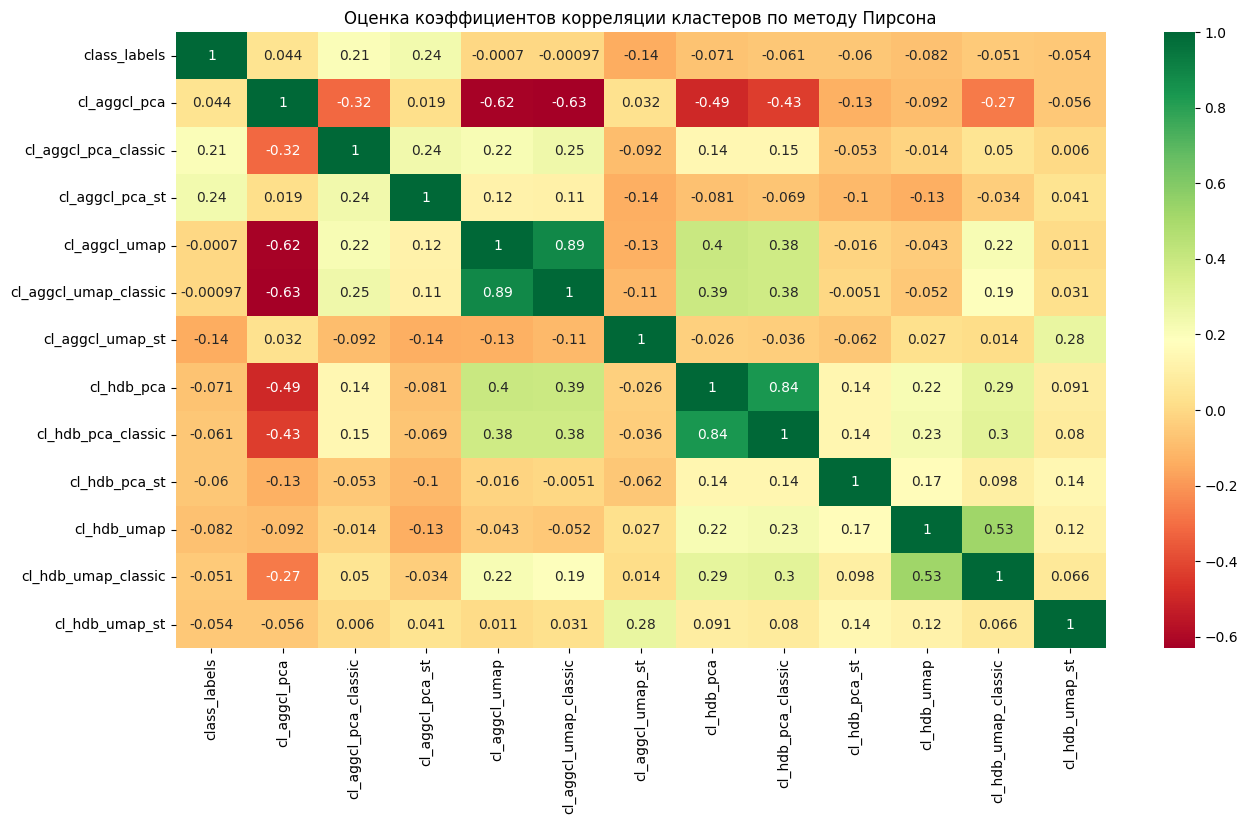

In [551]:
corr_matrix = data_plus.corr()
sn.heatmap(corr_matrix, annot=True, cmap='RdYlGn')
plt.gcf().set_size_inches(15, 8)
plt.title('Оценка коэффициентов корреляции кластеров по методу Пирсона')
plt.show()

C:\Users\user\anaconda3\envs\text13\lib\site-packages\phik\data_quality.py:59: UserWarning:

The number of unique values of variable text is large: 1752. Are you sure this is not an interval variable? Analysis for pairs of variables including text can be slow.



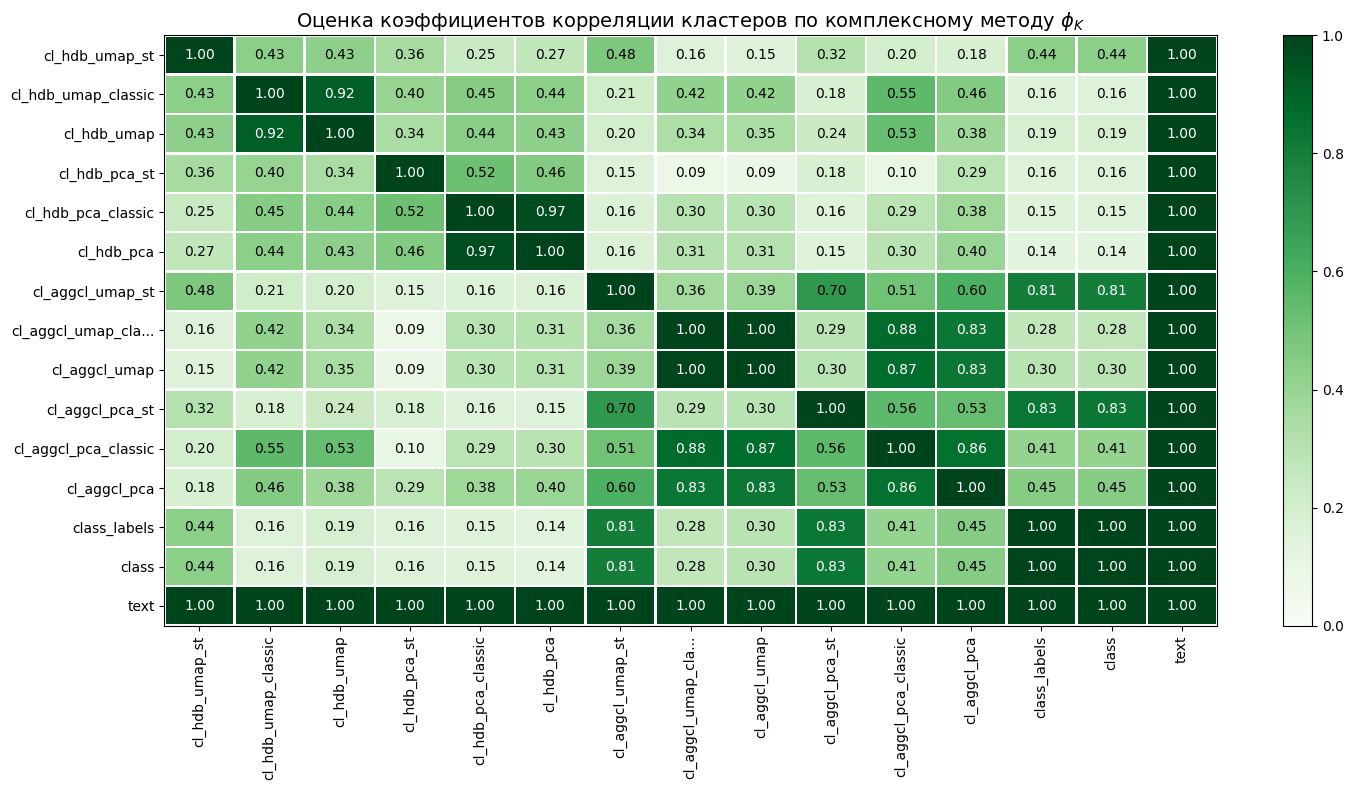

In [552]:
interval_cols = ['class_labels', 
                 'cl_aggcl_pca', 'cl_aggcl_pca_classic', 'cl_aggcl_pca_st', 
                 'cl_aggcl_umap', 'cl_aggcl_umap_classic', 'cl_aggcl_umap_st', 
                 'cl_hdb_pca', 'cl_hdb_pca_classic', 'cl_hdb_pca_st', 
                 'cl_hdb_umap', 'cl_hdb_umap_classic', 'cl_hdb_umap_st']

phik_overview = data_plus.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r'Оценка коэффициентов корреляции кластеров по комплексному методу $\phi_K$', 
                        fontsize_factor=1, 
                        figsize=(15, 8))
plt.tight_layout()

In [553]:
try:
    with open(f'{INTERNAL_FILES_PATH}/stop_words_russian.json', 'rb') as f:
        ru_stop_words = json.load(f)
        print('OK')
except Exception as E:
    print('ERROR', E)

OK


In [554]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range,
    stop_words=ru_stop_words).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.clusters)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {
        label: [words[j] for j in indices[i]][::-1] for i, label in enumerate(labels)
    }
    return top_n_words

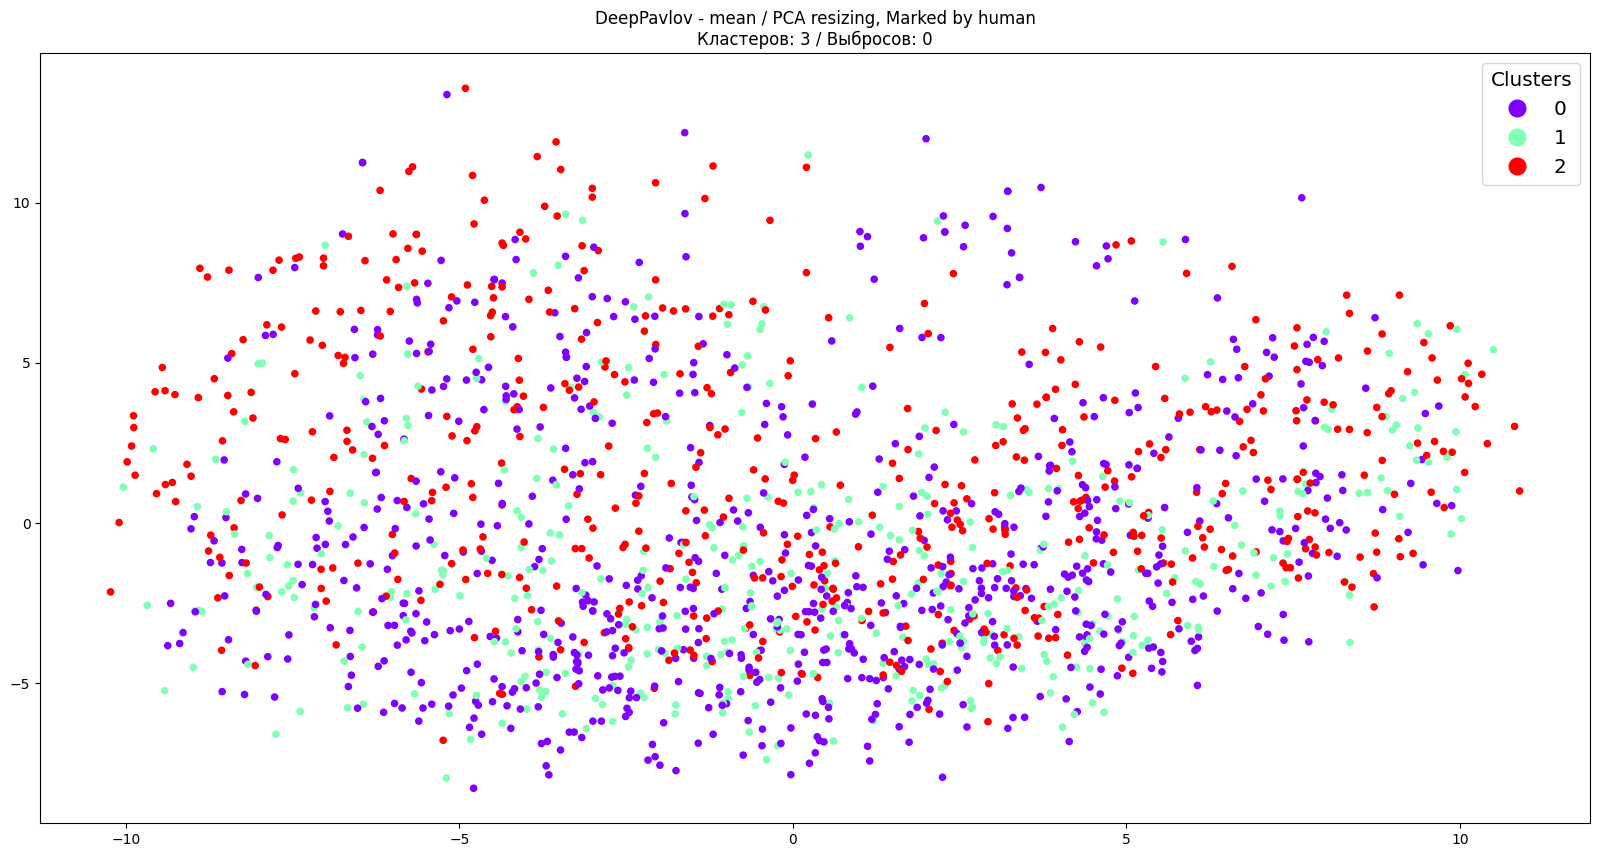

0            1          2
0     заказ      очередь      товар
1  доставка        талон  витринный
2  доставки  электронный    образец
3    курьер       кассир    витрины
4  доставку      очереди      пакет
5       час     продавец     товара
6    заказа     магазине   упаковка
7  позвонил        кассе  проверять
8     товар   сотрудники      сайте
9   наличии       услуги   магазине

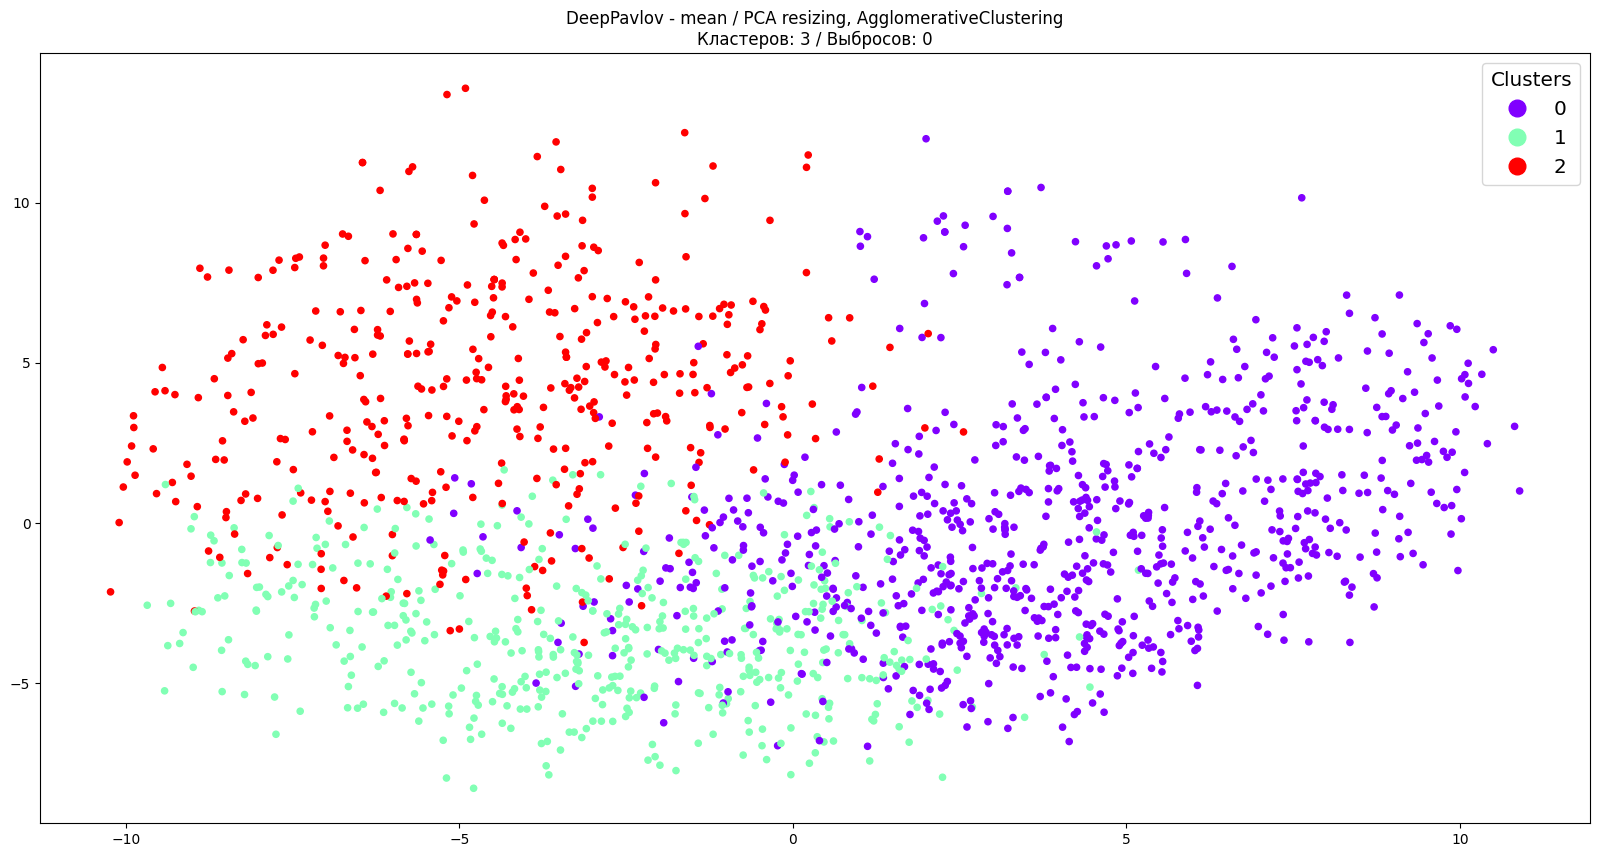

0         1          2
0     товар     заказ   доставка
1     заказ  доставки      товар
2   наличии     товар     долгая
3  магазине  доставку  проверять
4    товара    заказа     товара
5     никто    курьер   привезли
6  доставка  доставка   упаковка
7  доставки        00    образец
8   _x000d_     минут      заказ
9    курьер       час  витринный

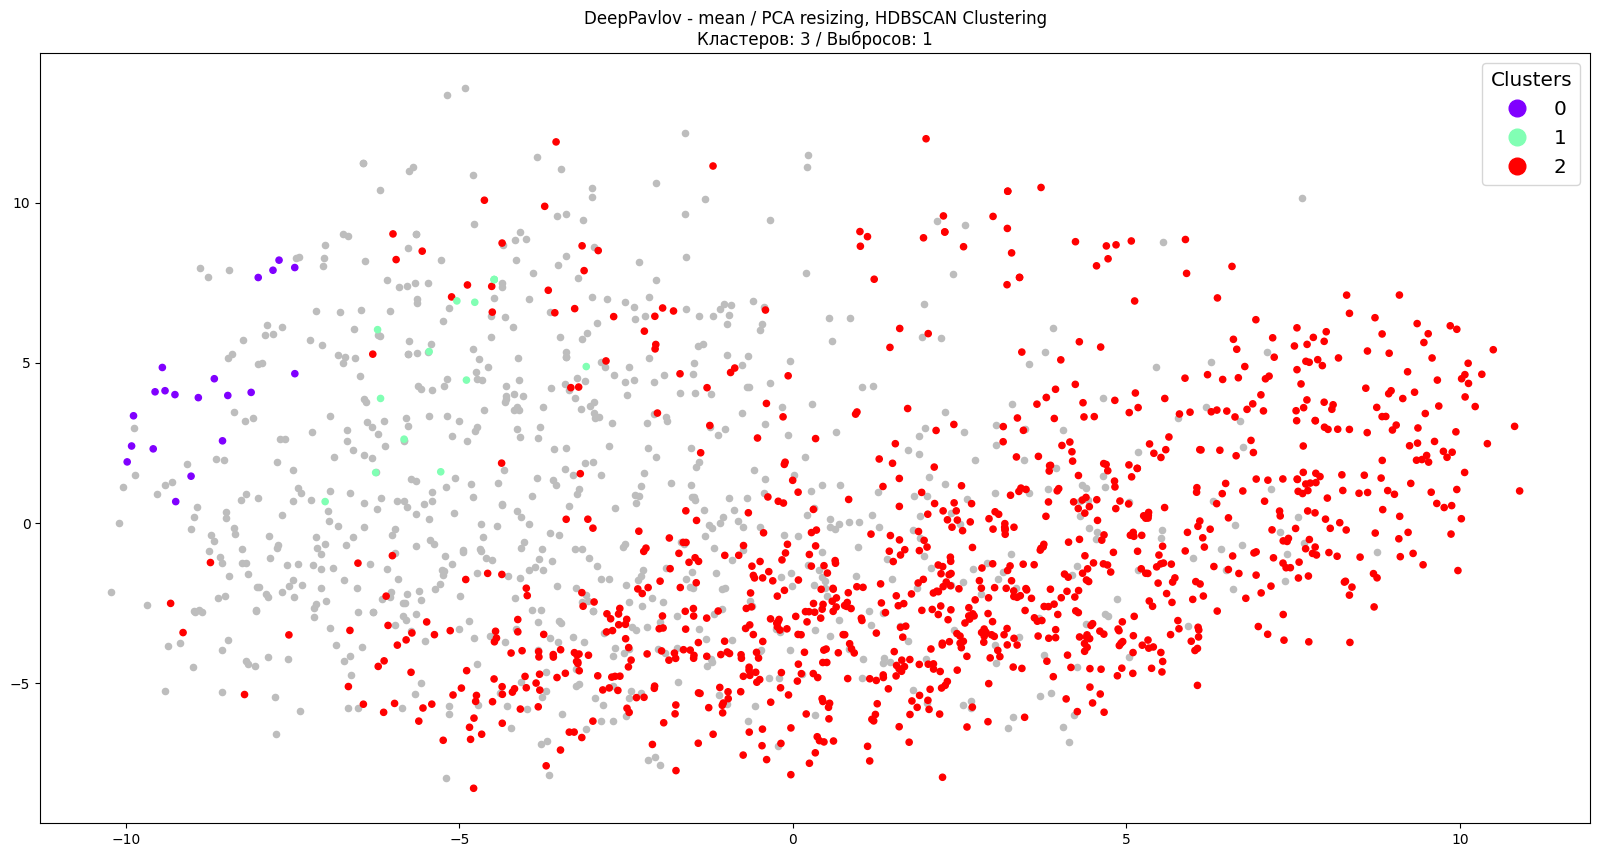

-1              0              1         2
0  доставка      проверять         долгая     заказ
1   очередь      отправкой       доставка     товар
2     товар      доставкой   неоднократно  доставки
3     заказ          товар         недели    заказа
4   магазин       наладить           дату    курьер
5  магазине       качество      расстроил    товара
6  привезли         прежде  передвигалась   наличии
7   _x000d_    руководству           факт  доставка
8    товара       найдется  ориентировали       час
9  доставки  рекомендуется     переносами  доставку

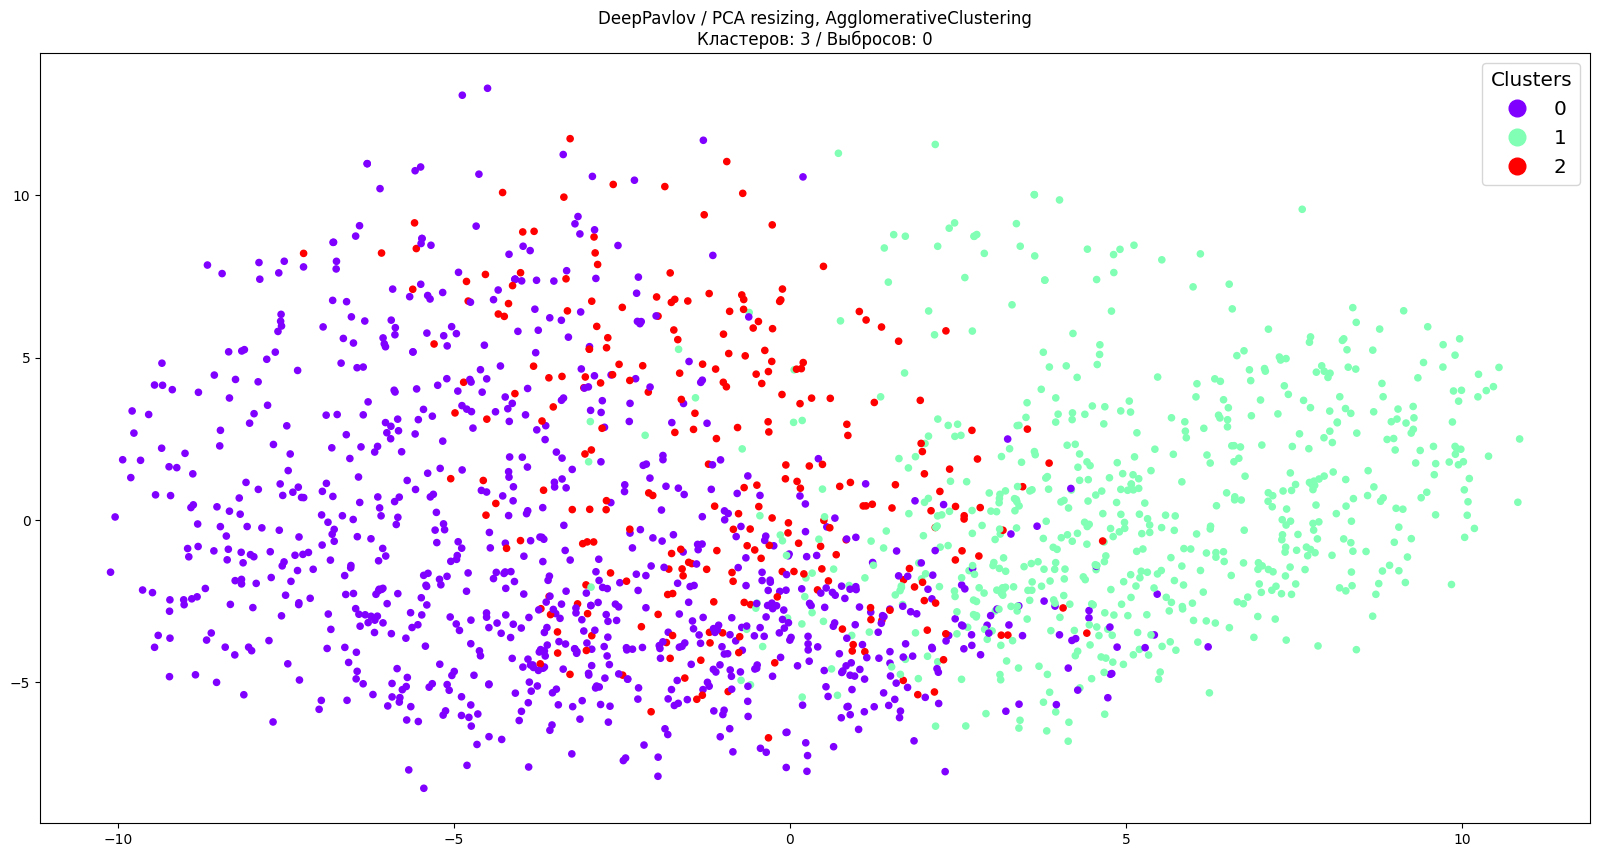

0          1            2
0     заказ      товар     упаковка
1  доставка      заказ        товар
2  доставки      никто       кассир
3     товар     курьер     привезли
4    заказа    наличии      коробка
5    курьер     товара     продавец
6  доставку   магазине     доставка
7    товара       этаж    персонала
8     минут  витринный        плохо
9     итоге   привезли  холодильник

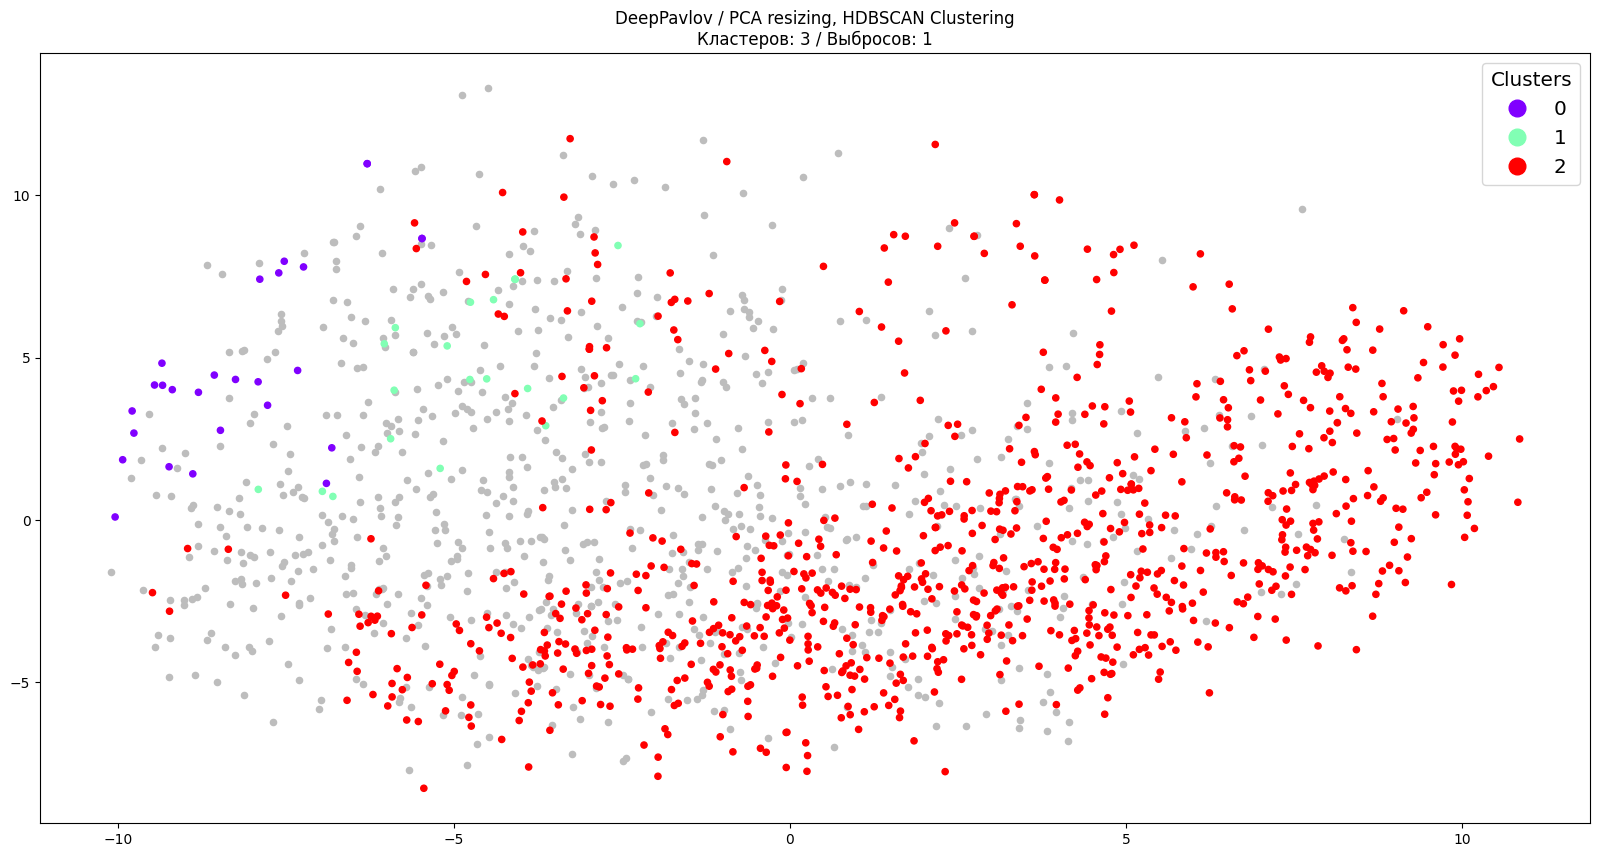

-1            0             1         2
0  доставка    проверять        долгая     заказ
1     товар    отправкой      доставка     товар
2   очередь        товар    переносили  доставки
3     заказ    доставкой     задержали    курьер
4   магазин     образцом          дату    заказа
5  магазине     наладить  неоднократно    товара
6  доставки   покупателю  переносилась  доставка
7  привезли  бракованный        недели   наличии
8    товара     качество          раза     итоге
9  пришлось       товары          дней       час

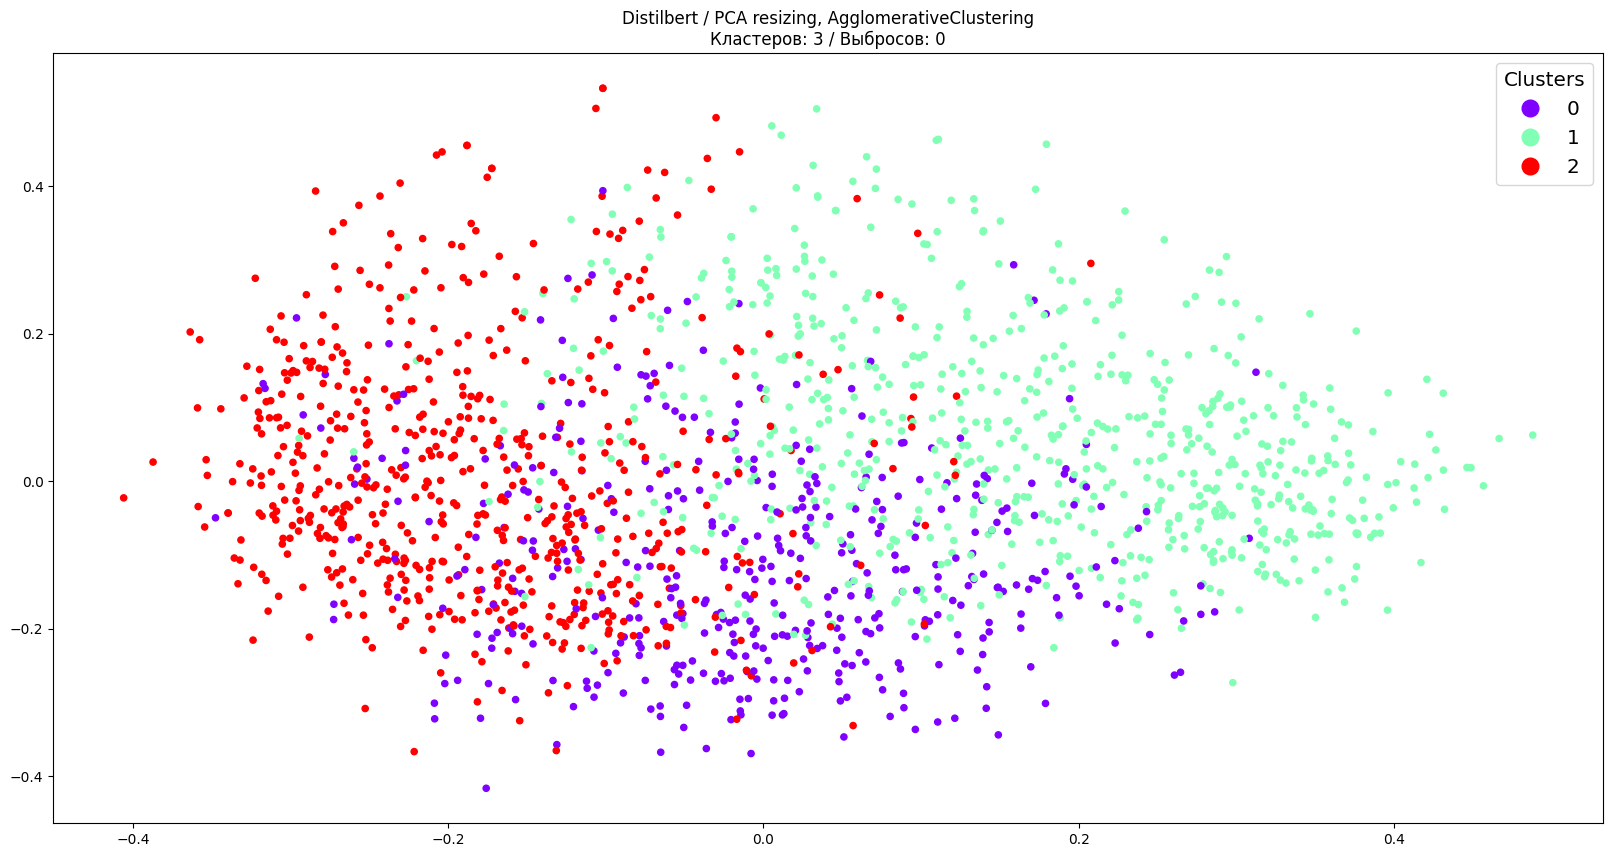

0         1          2
0        товар     заказ      товар
1     магазине  доставка      пакет
2    проверять  доставки   упаковка
3        талон    курьер  витринный
4    проверить  доставку    _x000d_
5       товара       час   продавец
6    витринный    заказа    образец
7      очередь  позвонил   привезли
8  электронный        00    коробка
9     интернет     итоге     товара

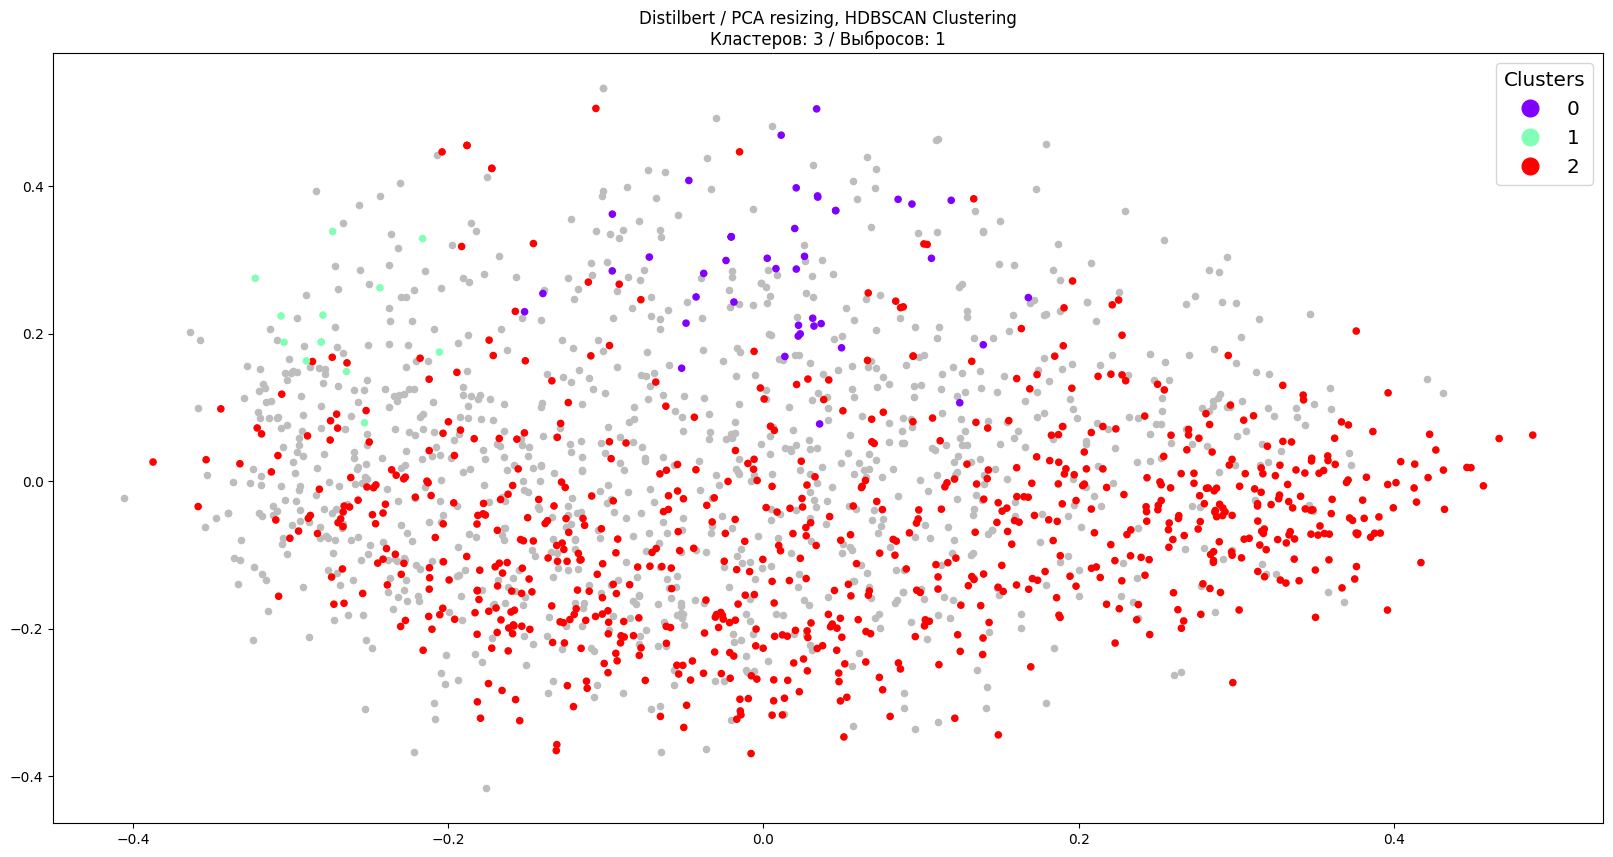

-1            0             1         2
0     товар     доставка         товар     заказ
1     заказ       долгая   бракованный     товар
2  доставка     доставки  повреждённый  доставки
3    товара   переносили        браком   _x000d_
4  магазине      платная        пришёл    курьер
5    заказа         дату     доставлен  позвонил
6   очередь   бесплатная        помята        00
7    выдачи    доставкой    неисправен  доставку
8   магазин  задержалась        стенка     итоге
9  доставки     наладить     поцарапан    заказа

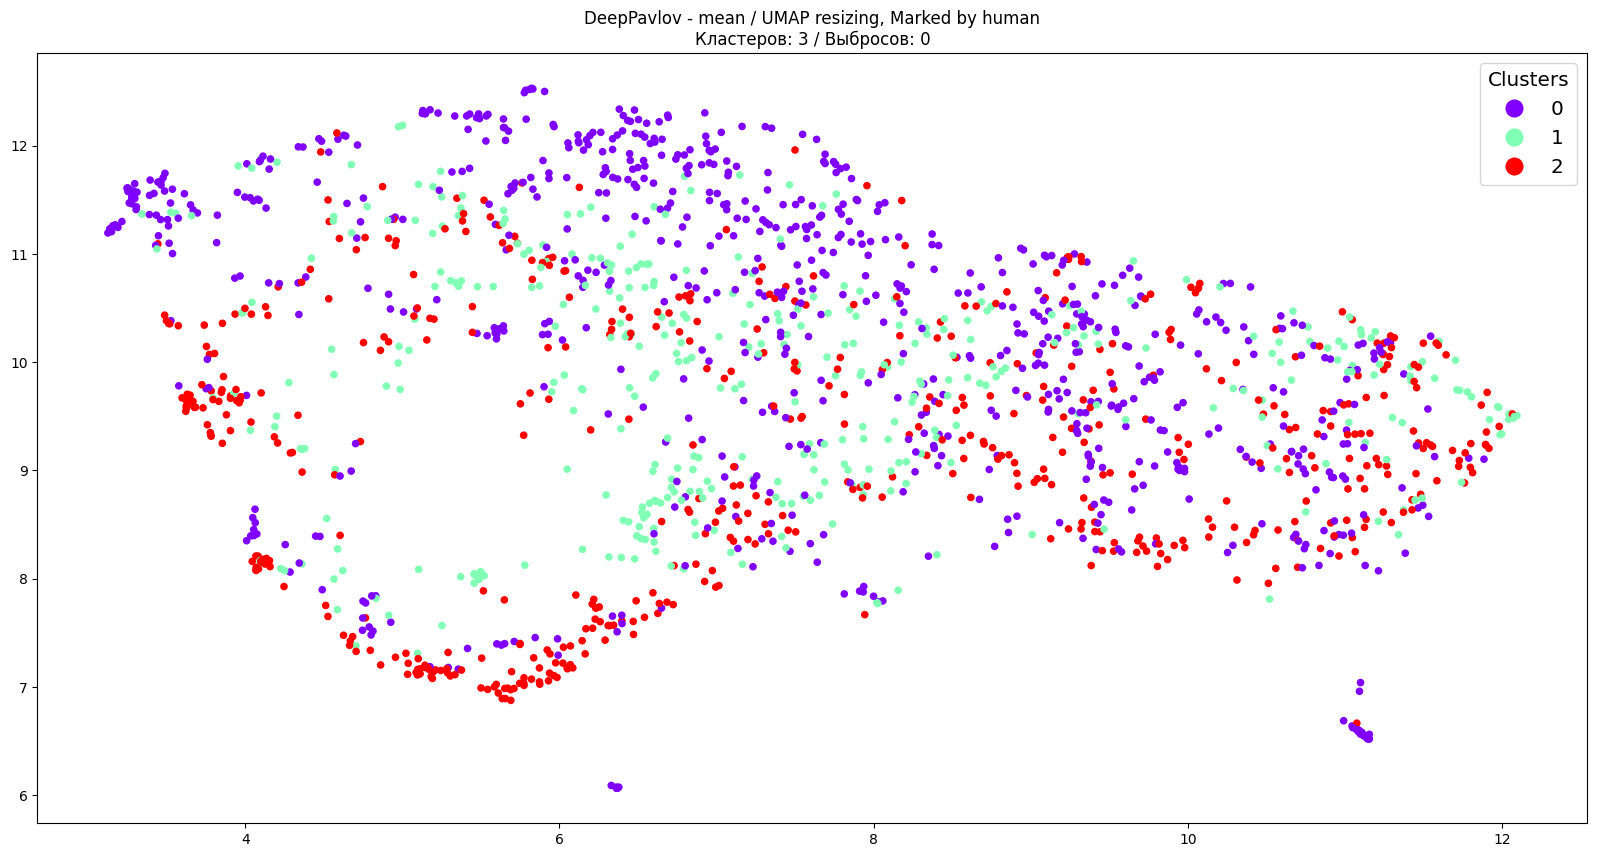

0            1          2
0     заказ      очередь      товар
1  доставка        талон  витринный
2  доставки  электронный    образец
3    курьер       кассир    витрины
4  доставку      очереди      пакет
5       час     продавец     товара
6    заказа     магазине   упаковка
7  позвонил        кассе  проверять
8     товар   сотрудники      сайте
9   наличии       услуги   магазине

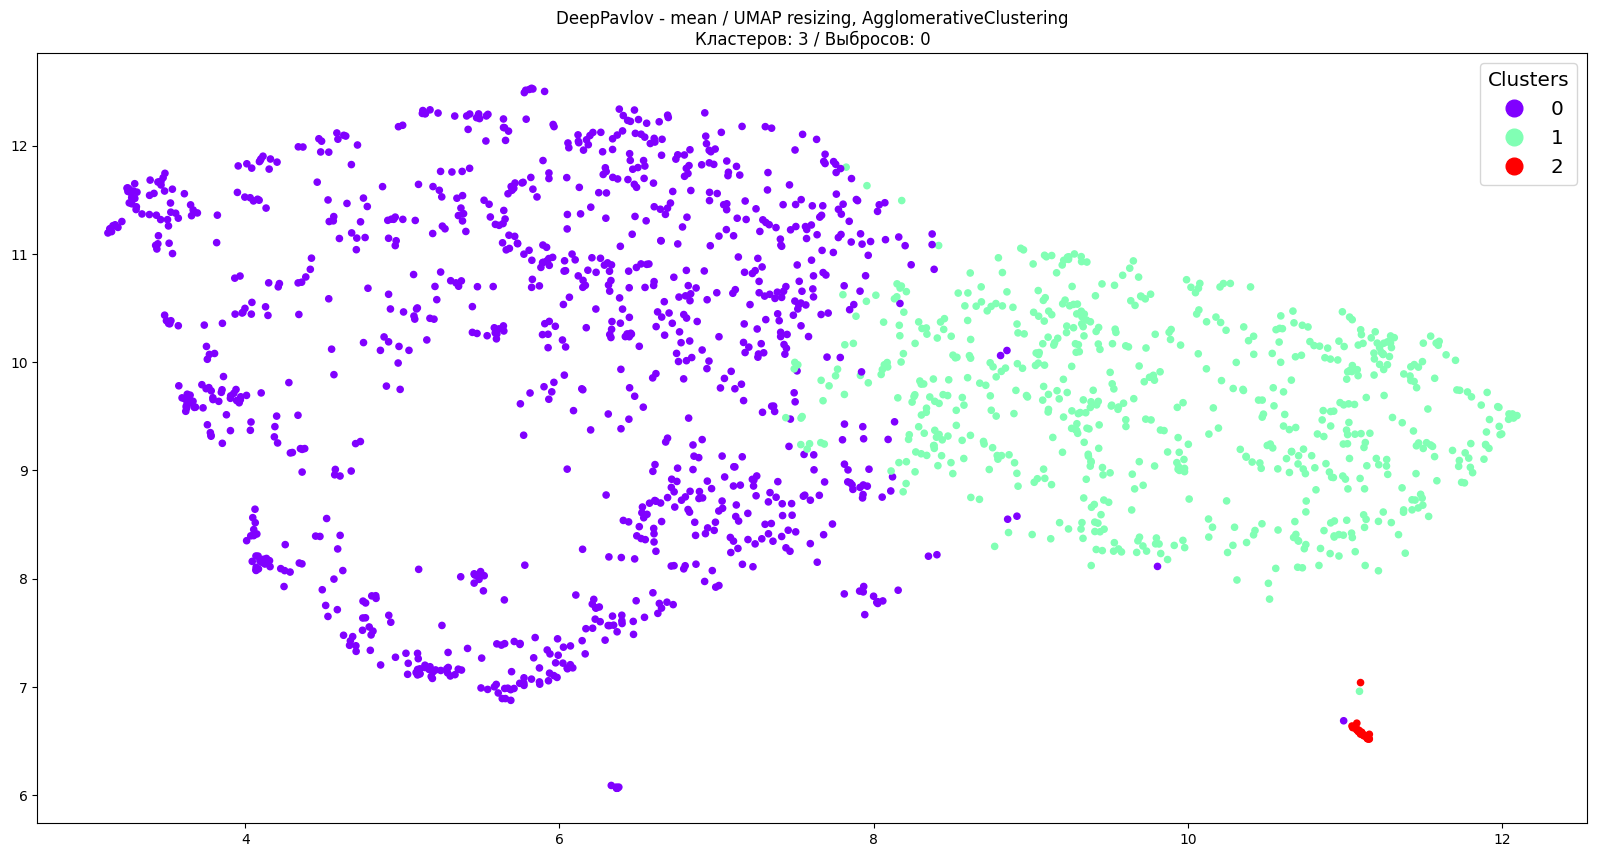

0          1          2
0     заказ      товар   привезли
1  доставка      заказ      товар
2     товар      никто   прислали
3  доставки     товара  доставили
4    заказа    наличии     выдали
5    курьер   магазине    заказан
6   магазин      сайте       цвет
7  доставку     курьер      чехол
8    товара    _x000d_     вместо
9     итоге  витринный    встречу

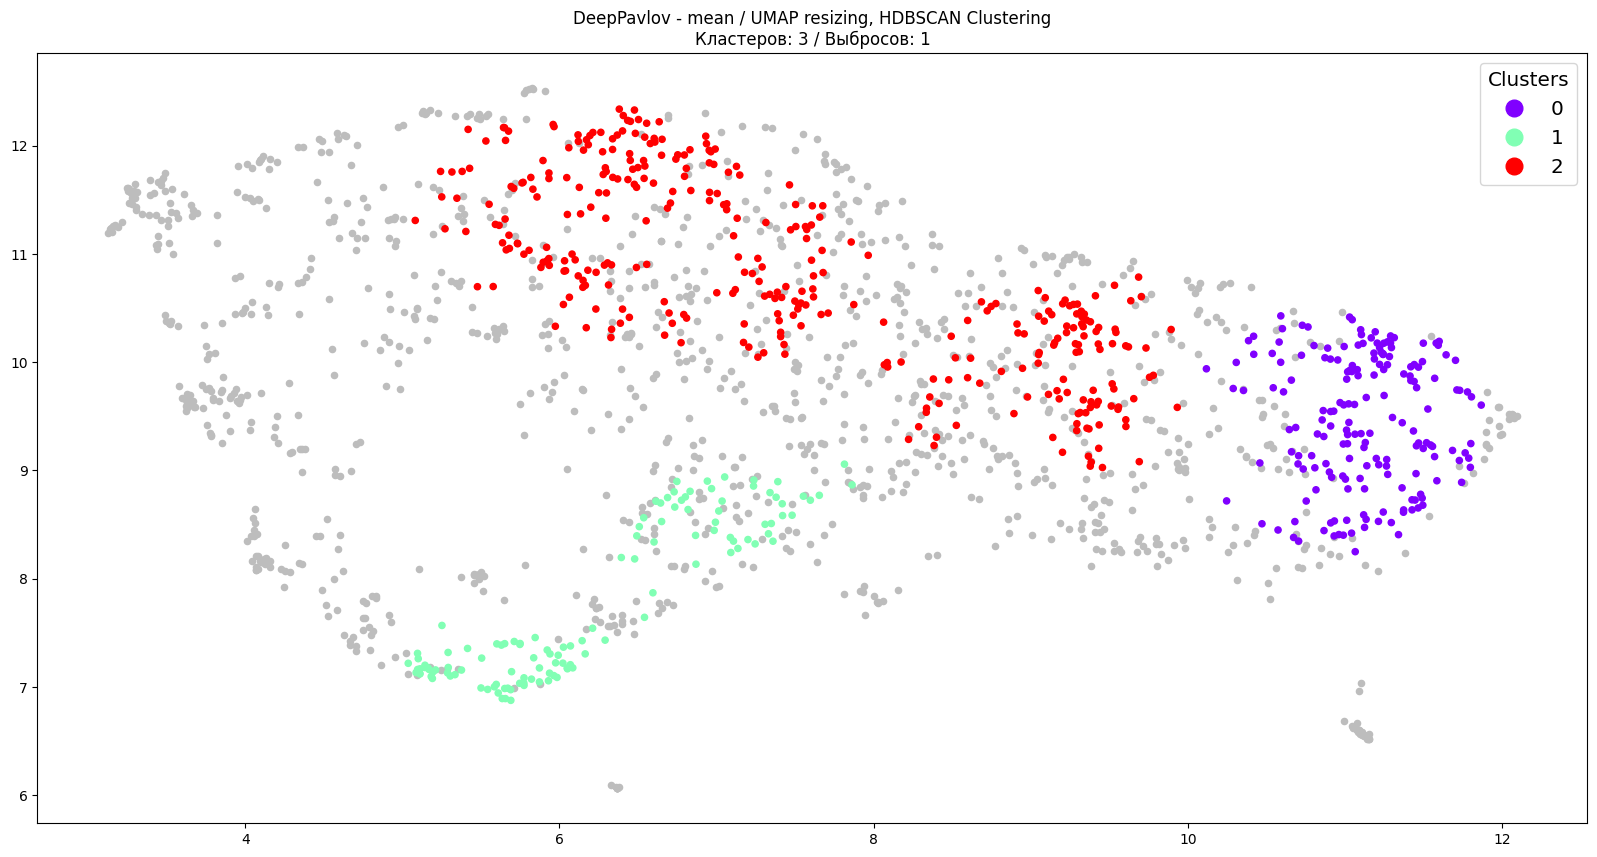

-1          0          1         2
0     товар      никто   упаковка     заказ
1     заказ     вообще      товар  доставки
2  доставка    образец    коробка     товар
3    товара  витринный   привезли    курьер
4  доставки    никакой    ужасная    заказа
5   _x000d_    наличии    пыльная  доставка
6    заказа      товар  неприятно  доставку
7  магазине      заказ   персонал  пришлось
8   магазин    указано     пришёл       час
9    курьер     скидки    вмятина     итоге

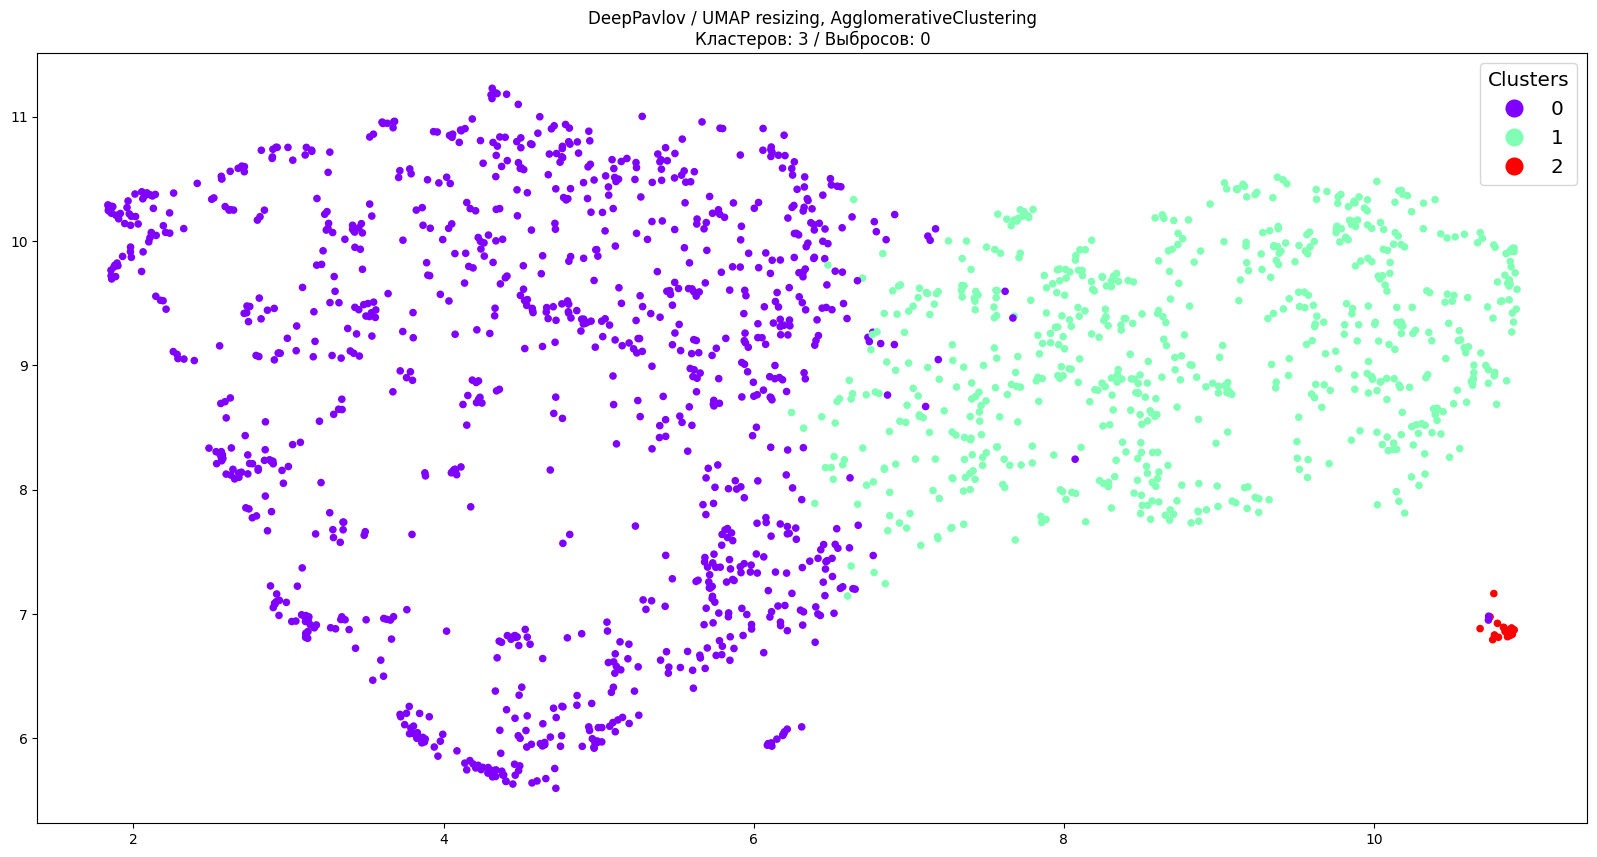

0         1           2
0     заказ     товар    привезли
1  доставка     заказ       товар
2     товар     никто    прислали
3  доставки   наличии   доставили
4    заказа    товара      выдали
5    курьер  магазине     заказан
6    товара   _x000d_        цвет
7  доставку     сайте       чехол
8     минут    курьер  заказывала
9       час    вообще      вместо

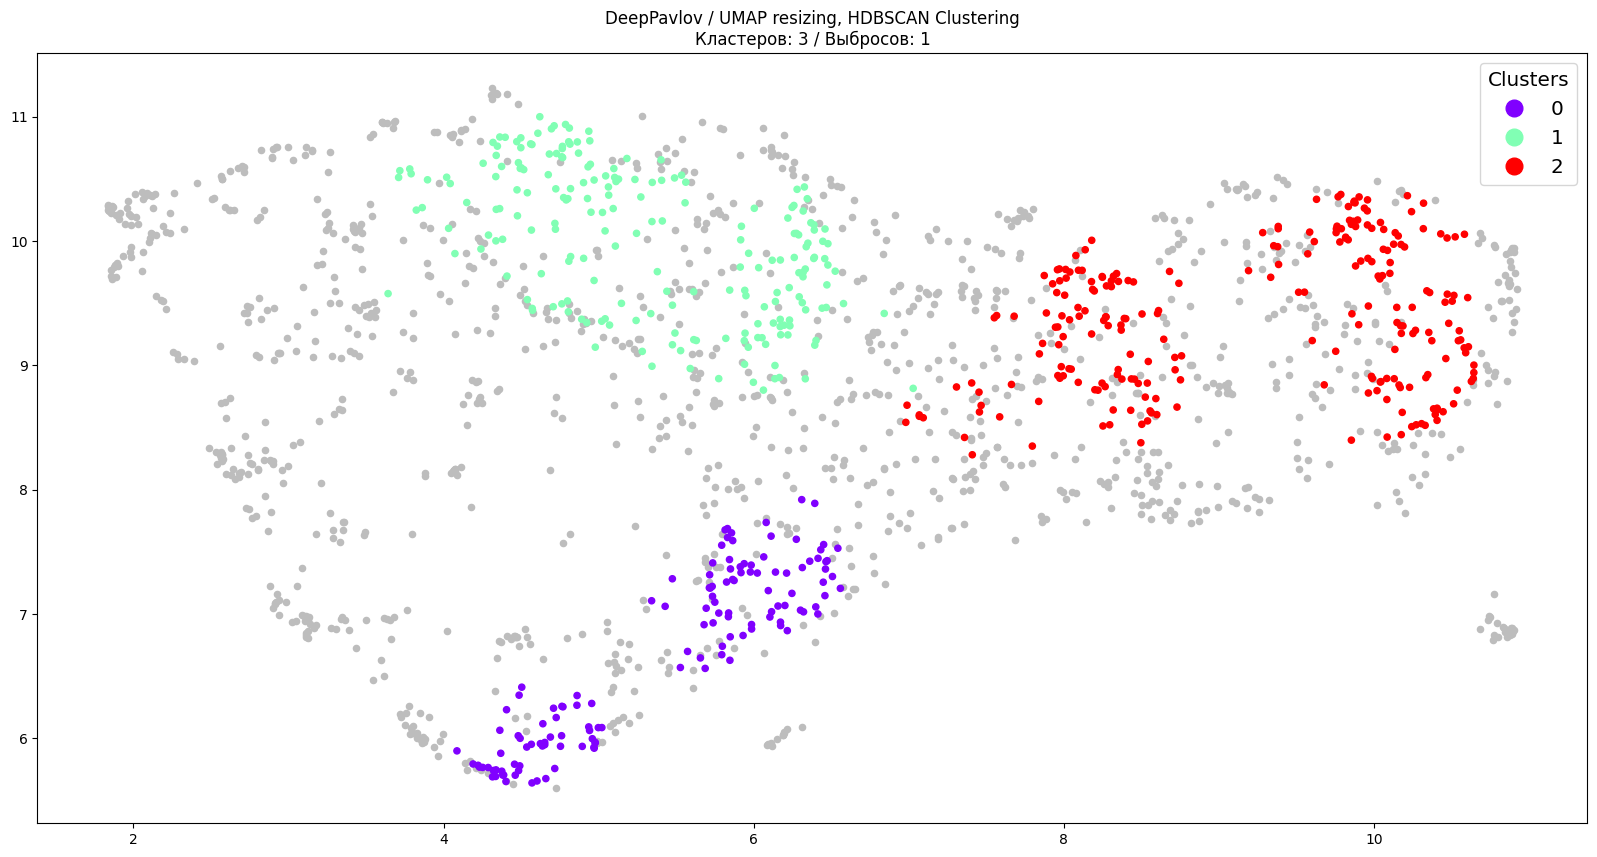

-1          0         1          2
0     товар      товар     заказ      заказ
1     заказ   доставка  доставки      товар
2  доставка   упаковка  доставку      никто
3    товара    коробка  доставка     курьер
4    заказа    пыльная    курьер  витринный
5  доставки   привезли     товар    наличии
6   магазин    ужасная     итоге     вообще
7   _x000d_  неприятно        22    образец
8  магазине     пришел       час     товара
9    курьер      следы        00   пришлось

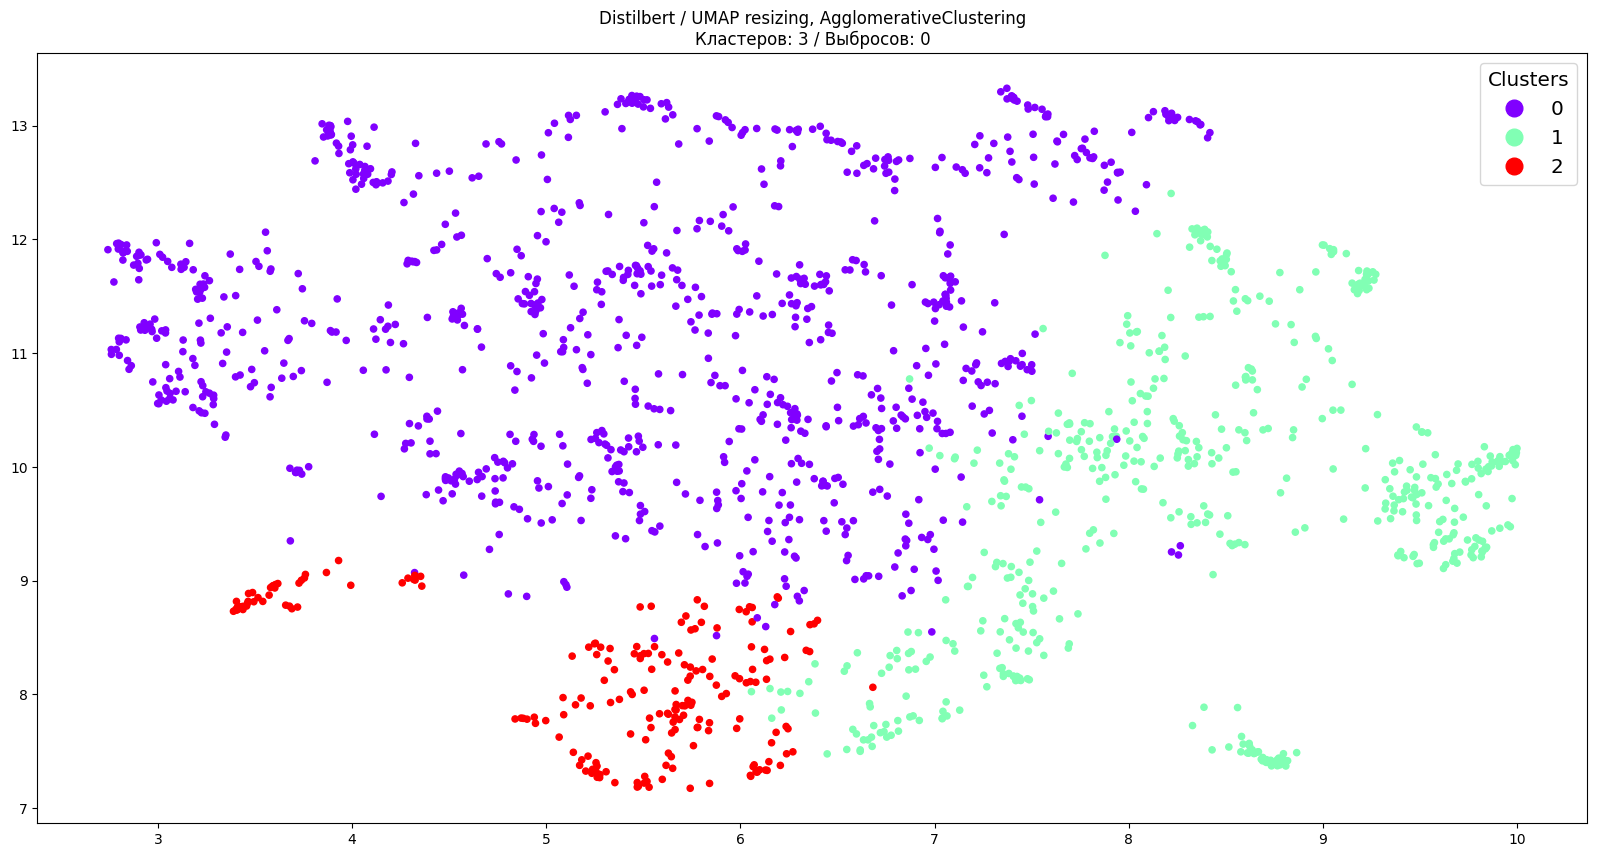

0         1              2
0      товар     заказ      проверять
1  витринный  доставки        хамство
2   доставка       час    сотрудников
3      заказ  доставка         кассир
4     товара  позвонил  консультантов
5    образец        00      продавцов
6   привезли    курьер          товар
7    витрины    заказа       продавцы
8   магазине     минут       магазина
9    _x000d_  доставку       продавец

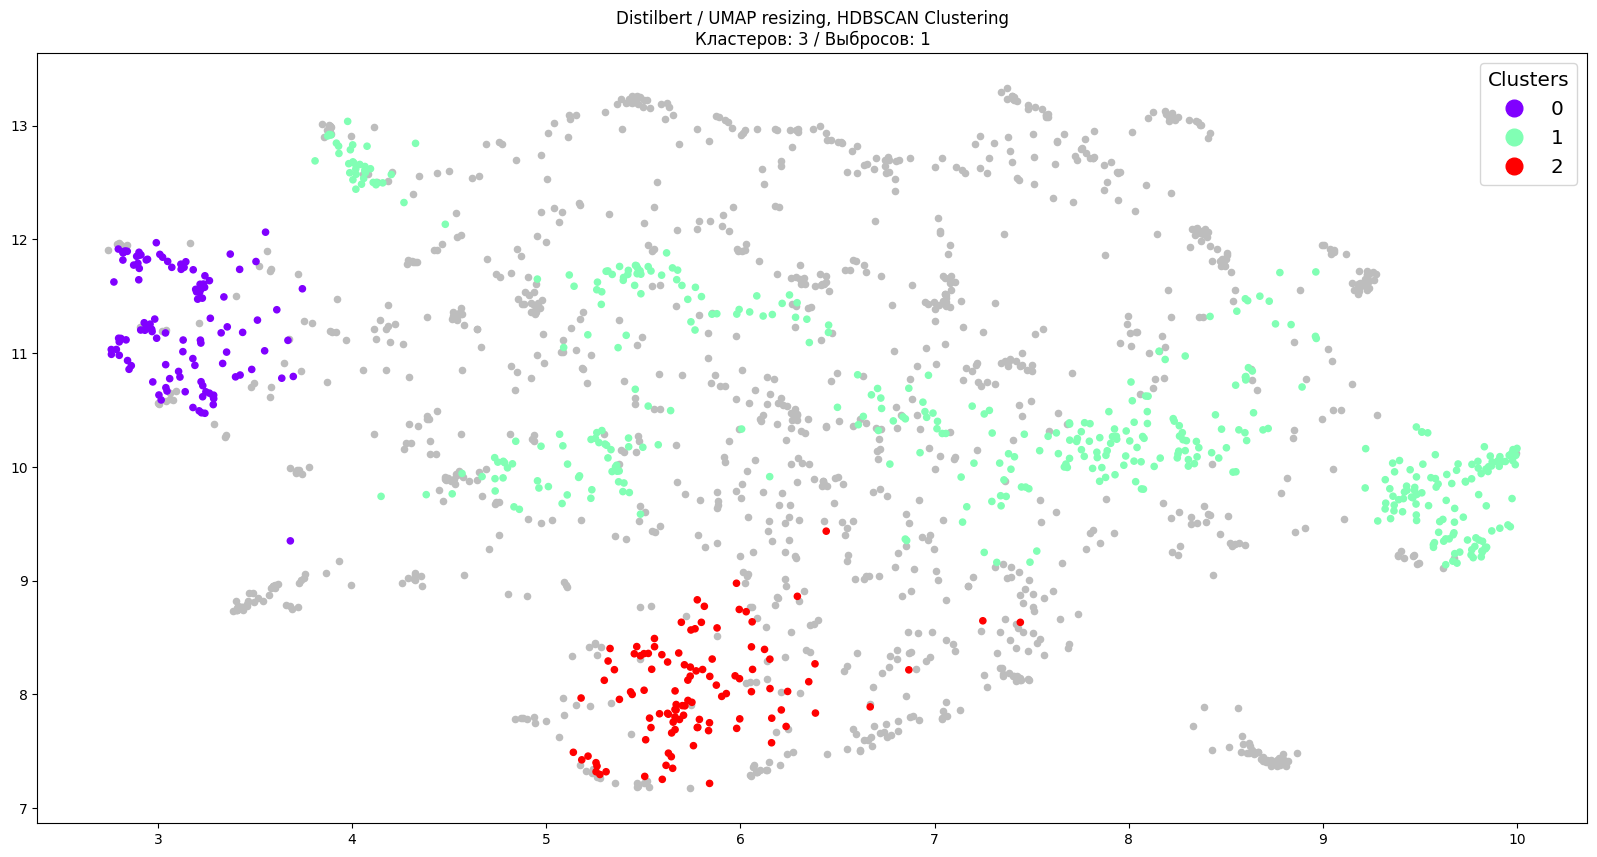

-1         0         1            2
0     товар     пакет  доставки   сотрудники
1     заказ  упаковка     заказ       кассир
2  доставка   коробку     товар    персонала
3    товара   коробка       час     продавцы
4  пришлось      пыль  позвонил  сотрудников
5   очередь  упаковки        00    продавцов
6  магазине   вскрыта    курьер     персонал
7    заказа   подарок  доставка    клиентами
8   _x000d_   пыльную  доставку     магазине
9    выдачи   коробки  привезли      хамство

In [555]:
for emb, clusters, title_ in [
    [emb_pca_2d, data_plus['class_labels'], 'DeepPavlov - mean / PCA resizing, Marked by human'], 
    [emb_pca_2d, clustering_aggcl_pca, 'DeepPavlov - mean / PCA resizing, AgglomerativeClustering'], 
    [emb_pca_2d, clustering_hdbscan_pca, 'DeepPavlov - mean / PCA resizing, HDBSCAN Clustering'],
    [emb_classic_pca_2d, clustering_aggcl_pca_classic, 'DeepPavlov / PCA resizing, AgglomerativeClustering'],
    [emb_classic_pca_2d, clustering_hdbscan_pca_classic, 'DeepPavlov / PCA resizing, HDBSCAN Clustering'],
    [emb_st_pca_2d, clustering_aggcl_pca_st, 'Distilbert / PCA resizing, AgglomerativeClustering'],
    [emb_st_pca_2d, clustering_hdbscan_pca_st, 'Distilbert / PCA resizing, HDBSCAN Clustering'],
    [emb_umap_2d, data_plus['class_labels'], 'DeepPavlov - mean / UMAP resizing, Marked by human'], 
    [emb_umap_2d, clustering_aggcl_umap, 'DeepPavlov - mean / UMAP resizing, AgglomerativeClustering'],
    [emb_umap_2d, clustering_hdbscan_umap, 'DeepPavlov - mean / UMAP resizing, HDBSCAN Clustering'],
    [emb_classic_umap_2d, clustering_aggcl_umap_classic, 'DeepPavlov / UMAP resizing, AgglomerativeClustering'],
    [emb_classic_umap_2d, clustering_hdbscan_umap_classic, 'DeepPavlov / UMAP resizing, HDBSCAN Clustering'],
    [emb_st_umap_2d, clustering_aggcl_umap_st, 'Distilbert / UMAP resizing, AgglomerativeClustering'],
    [emb_st_umap_2d, clustering_hdbscan_umap_st, 'Distilbert / UMAP resizing, HDBSCAN Clustering']
]:
                         
    df = pd.DataFrame(emb, columns=['x', 'y'])
    df['clusters'] = clusters
    outliers = df.loc[df['clusters'] == -1, :]
    clustered = df.loc[df['clusters'] != -1, :]
    
    fig, ax = plt.subplots(figsize=(20, 10))
    outliers_ = ax.scatter(outliers.x, outliers.y, color='#BDBDBD', s=20)
    clustered_ = ax.scatter(clustered.x, clustered.y, c=clustered.clusters, s=20, cmap='rainbow')
    
    plt.title(f'{title_}\nКластеров: {clustered.clusters.nunique()} / Выбросов: {outliers.clusters.nunique()}')
    
    legend = ax.legend(*clustered_.legend_elements(),
                       loc='upper right', title='Clusters',
                       fontsize='x-large', title_fontsize='x-large',
                       markerscale=2)
        
    plt.show();
    df['text'] = data['text']
    docs_per_topic = df.groupby(['clusters'], as_index = False).agg({'text': ' '.join})
    
    tf_idf, count = c_tf_idf(docs_per_topic['text'].values, m=len(data))
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=10)
    
    display(pd.DataFrame(top_n_words))

### Key phrase

In [557]:
import yake

In [567]:
pyake = yake.KeywordExtractor(lan="ru",n=1)

In [573]:
full_text_raw = ' '.join(data['text'])
full_text_lemmatized = ' '.join(data_lemmatized['text'])

result = pyake.extract_keywords(full_text)
result_lemm = pyake.extract_keywords(full_text_lemmatized)

print(pd.DataFrame(result))
print()
print(pd.DataFrame(result_lemm))

            0         1
0       Заказ  0.000224
1       Товар  0.000253
2    доставка  0.000593
3    доставки  0.000941
4      Курьер  0.001241
5      товара  0.001460
6      заказа  0.001582
7    Привезли  0.001886
8    пришлось  0.002080
9    магазине  0.002080
10    магазин  0.002151
11   доставку  0.002614
12      итоге  0.002726
13  Витринный  0.003015
14        час  0.003025
15    наличии  0.003285
16   позвонил  0.003912
17    очередь  0.004154
18     выдачи  0.004323
19      минут  0.004829

              0         1
0         заказ  0.000025
1      доставка  0.000029
2         товар  0.000030
3       магазин  0.000069
4        курьер  0.000110
5           час  0.000137
6        выдача  0.000140
7     позвонить  0.000165
8     привозить  0.000167
9     проверять  0.000177
10   доставлять  0.000189
11   оплачивать  0.000221
12    приходить  0.000222
13  приходиться  0.000227
14    сотрудник  0.000253
15    витринный  0.000254
16         итог  0.000270
17      очередь  0.000289
1